<a href="https://colab.research.google.com/github/CarlosEduardo254/TrabalhoFinal_AprendMaquina/blob/main/TrabalhoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from google.colab import drive
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import wilcoxon
from sklearn.neighbors import *
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import wilcoxon
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

In [2]:
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Aprendizado de Maquina/Trabalho Final'

Mounted at /content/drive
/content/drive/MyDrive/Aprendizado de Maquina/Trabalho Final


Atributos:
- **Age**: idade do paciente [anos]
- **Sex**: sexo do paciente [M: Masculino, F: Feminino]
- **ChestPainType**: tipo de dor no peito [TA: Angina Típica, ATA: Angina Atípica, NAP: Dor Não Anginal, ASY: Assintomático]
- **RestingBP**: pressão arterial em repouso [mm Hg]
- **Cholesterol**: colesterol sérico [mm/dl]
- **FastingBS**: glicemia em jejum [1: se FastingBS > 120 mg/dl, 0: caso contrário]
- **RestingECG**: resultados do eletrocardiograma em repouso [Normal: Normal, ST: anormalidade na onda ST-T (inversões da onda T e/ou elevação/depressão do segmento ST > 0,05 mV), LVH: hipertrofia ventricular esquerda provável/definitiva pelos critérios de Estes]
- **MaxHR**: frequência cardíaca máxima alcançada [valor numérico entre 60 e 202]
- **ExerciseAngina**: angina induzida por exercício [Y: Sim, N: Não]
- **Oldpeak**: decréscimo do segmento ST [valor numérico]
- **ST_Slope**: inclinação do segmento ST no pico do exercício [Up: ascendente, Flat: plano, Down: descendente]
- **HeartDisease**: classe de saída [1: doença cardíaca, 0: Normal]




In [3]:
df = pd.read_csv('heart.csv')
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [4]:
df["HeartDisease"].value_counts()

,count
HeartDisease,
1,508
0,410


In [5]:
df.dtypes

,0
Age,int64
Sex,object
ChestPainType,object
RestingBP,int64
Cholesterol,int64
FastingBS,int64
RestingECG,object
MaxHR,int64
ExerciseAngina,object
Oldpeak,float64


Como podemos ver, os dados da string no dataframe estão na forma de objeto, precisamos convertê-los de volta em string para trabalhar nele

In [6]:
string_col = df.select_dtypes(include="object").columns
df[string_col]=df[string_col].astype("string")

### Obtendo as colunas categóricas:

In [7]:
string_col=df.select_dtypes("string").columns.to_list()

In [8]:
string_col

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

In [9]:
num_col=df.columns.to_list()
#print(num_col)
for col in string_col:
    num_col.remove(col)
num_col.remove("HeartDisease")

In [10]:
num_col

['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

In [11]:
df.describe(). T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [12]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


## Análise exploratória dos dados

Vamos investigar o conjunto de dados por meio de técnicas estatísticas e visualizações, para poder tirar conclusões sobre os dados.

HeartDisease
1    508
0    410
Name: count, dtype: int64


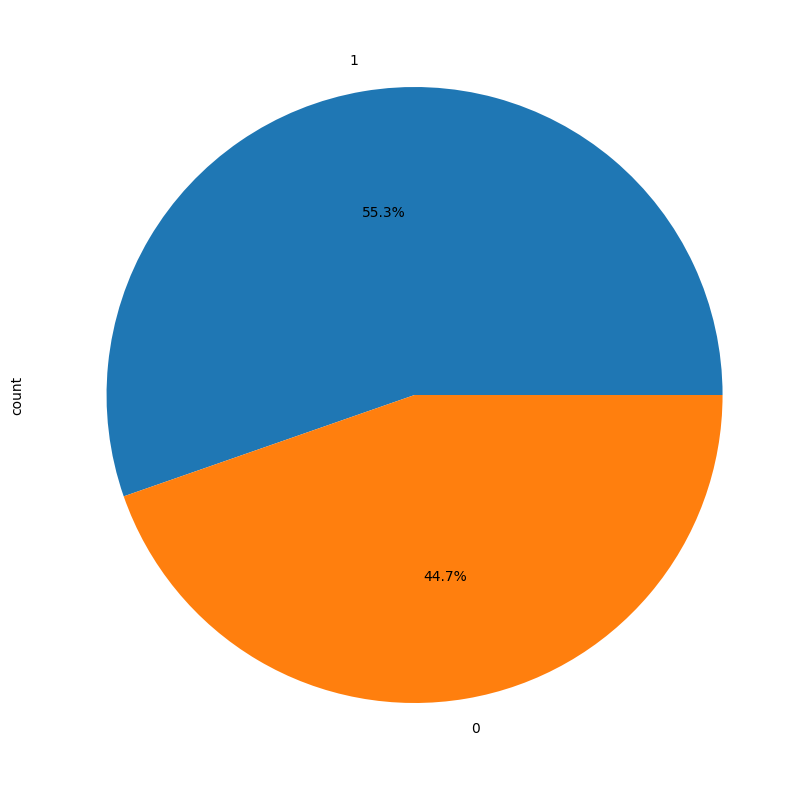

In [13]:
print(df["HeartDisease"].value_counts())
df["HeartDisease"].value_counts().plot(kind="pie", autopct='%1.1f%%', figsize=(10,10));

In [14]:
#describe para pacientes sem doenças do coração
df[df['HeartDisease']==0].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,410.0,50.551220,9.444915,28.0,43.00,51.0,57.00,76.0
RestingBP,410.0,130.180488,16.499585,80.0,120.00,130.0,140.00,190.0
Cholesterol,410.0,227.121951,74.634659,0.0,197.25,227.0,266.75,564.0
FastingBS,410.0,0.107317,0.309894,0.0,0.00,0.0,0.00,1.0
MaxHR,410.0,148.151220,23.288067,69.0,134.00,150.0,165.00,202.0
Oldpeak,410.0,0.408049,0.699709,-1.1,0.00,0.0,0.60,4.2
HeartDisease,410.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0


In [15]:
#describe para pacientes com doenças do coração
df[df['HeartDisease']==1].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,508.0,55.899606,8.727056,31.0,51.0,57.0,62.00,77.0
RestingBP,508.0,134.185039,19.828685,0.0,120.0,132.0,145.00,200.0
Cholesterol,508.0,175.940945,126.391398,0.0,0.0,217.0,267.00,603.0
FastingBS,508.0,0.334646,0.472332,0.0,0.0,0.0,1.00,1.0
MaxHR,508.0,127.655512,23.386923,60.0,112.0,126.0,144.25,195.0
Oldpeak,508.0,1.274213,1.151872,-2.6,0.0,1.2,2.00,6.2
HeartDisease,508.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0


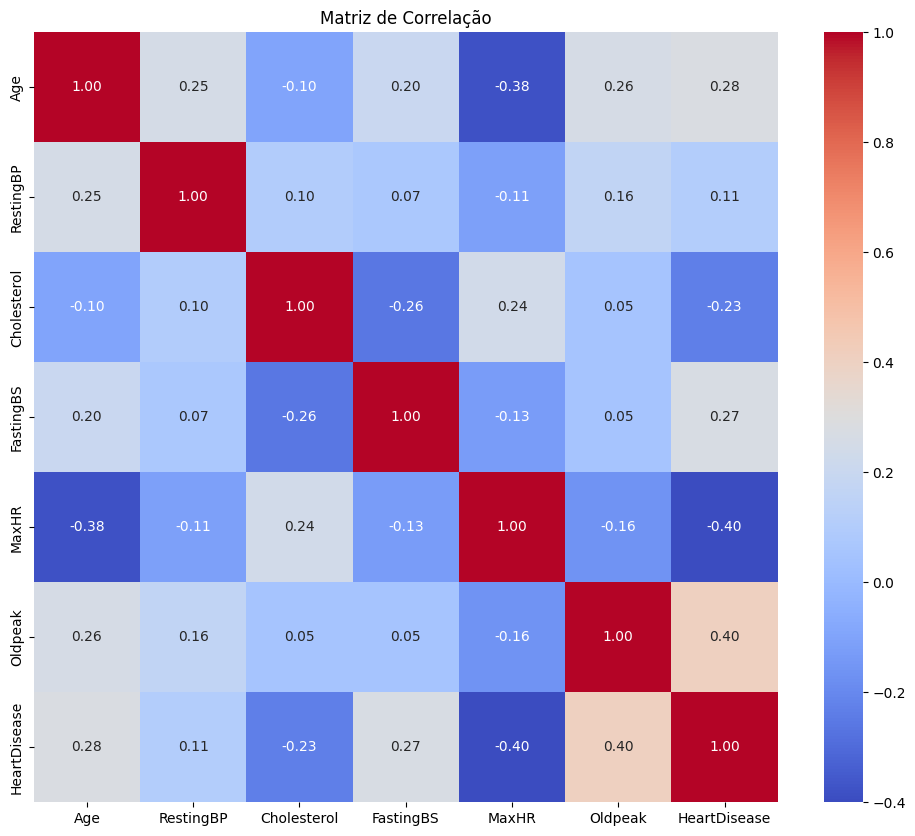

In [16]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.show()

Podemos observar que **HeartDisease** possui alta correlação negativa com **MaxHR** e correlação levemente negativa com **Cholesterol**, enquanto apresenta correlação positiva com **Oldpeak**, **FastingBS** e **RestingBP**.

In [17]:

fig=px.histogram(df,
                 x="HeartDisease",
                 color="Sex",
                 hover_data=df.columns,
                 title="Distribuição de Doenças Cardíacas",
                 barmode="group")
fig.show()

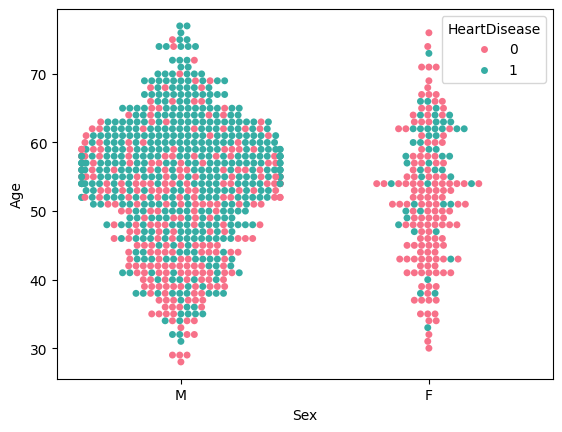

In [18]:
sns.swarmplot(y="Age", x="Sex", hue="HeartDisease", data=df, palette="husl");

Podemos perceber que o número de pessoas com doença cardíaca concentra-se especialmente em indivíduos do sexo masculino na faixa etária de 50 a 65 anos

In [19]:
fig=px.histogram(df,
                 x="ChestPainType",
                 color="Sex",
                 hover_data=df.columns,
                 title="Tipos de dor no peito"
                )
fig.show()

Poucos dados para TA, é um problema para o trabalho?

In [20]:
fig=px.histogram(df,
                 x="Sex",
                 hover_data=df.columns,
                 title="Distribuição por Sexo nos Dados")
fig.show()

<Axes: ylabel='count'>

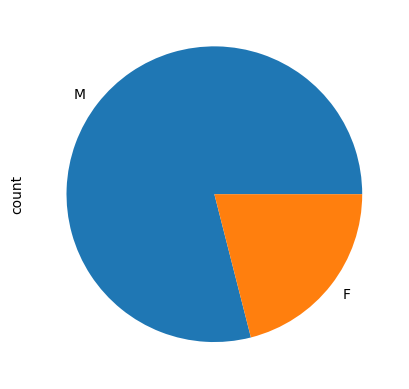

In [21]:
df['Sex'].value_counts().plot(kind='pie')

Muitos do sexo masculino e poucos do feminino, problema para o trabalho? Bruno disse não ser um problema, mas isso deve ser debatido no relatório

In [22]:
fig=px.histogram(df,
                 x="RestingECG",
                 hover_data=df.columns,
                 title="DIstribuição do Resting ECG")
fig.show()

In [23]:
df[num_col]

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
0,40,140,289,0,172,0.0
1,49,160,180,0,156,1.0
2,37,130,283,0,98,0.0
3,48,138,214,0,108,1.5
4,54,150,195,0,122,0.0
...,...,...,...,...,...,...
913,45,110,264,0,132,1.2
914,68,144,193,1,141,3.4
915,57,130,131,0,115,1.2
916,57,130,236,0,174,0.0


[]

<Figure size 1500x1000 with 0 Axes>

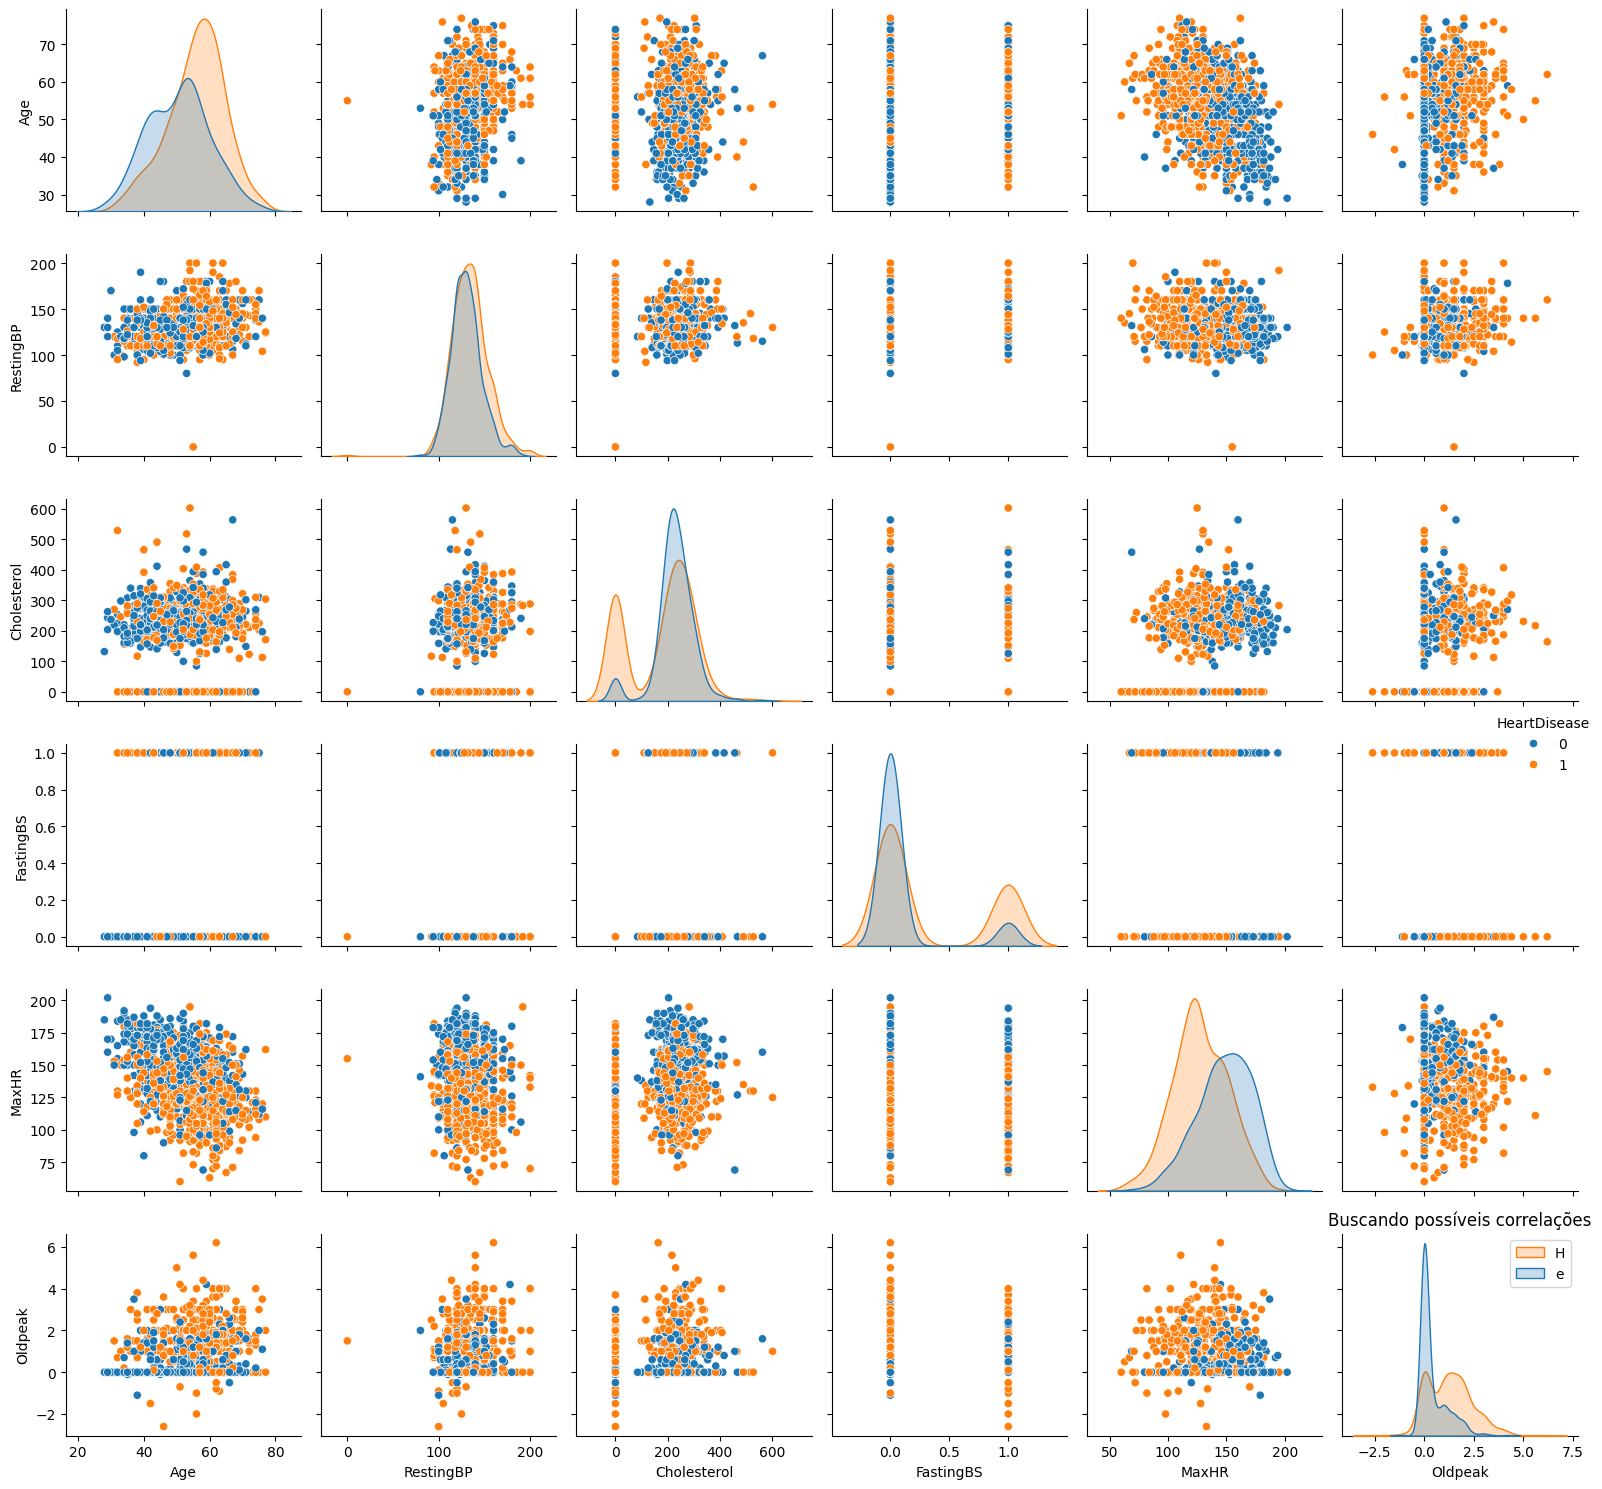

In [25]:
plt.figure(figsize=(15,10))
sns.pairplot(df,hue="HeartDisease")
plt.title("Buscando possíveis correlações")
plt.legend("HeartDisease")
plt.tight_layout()
plt.plot()

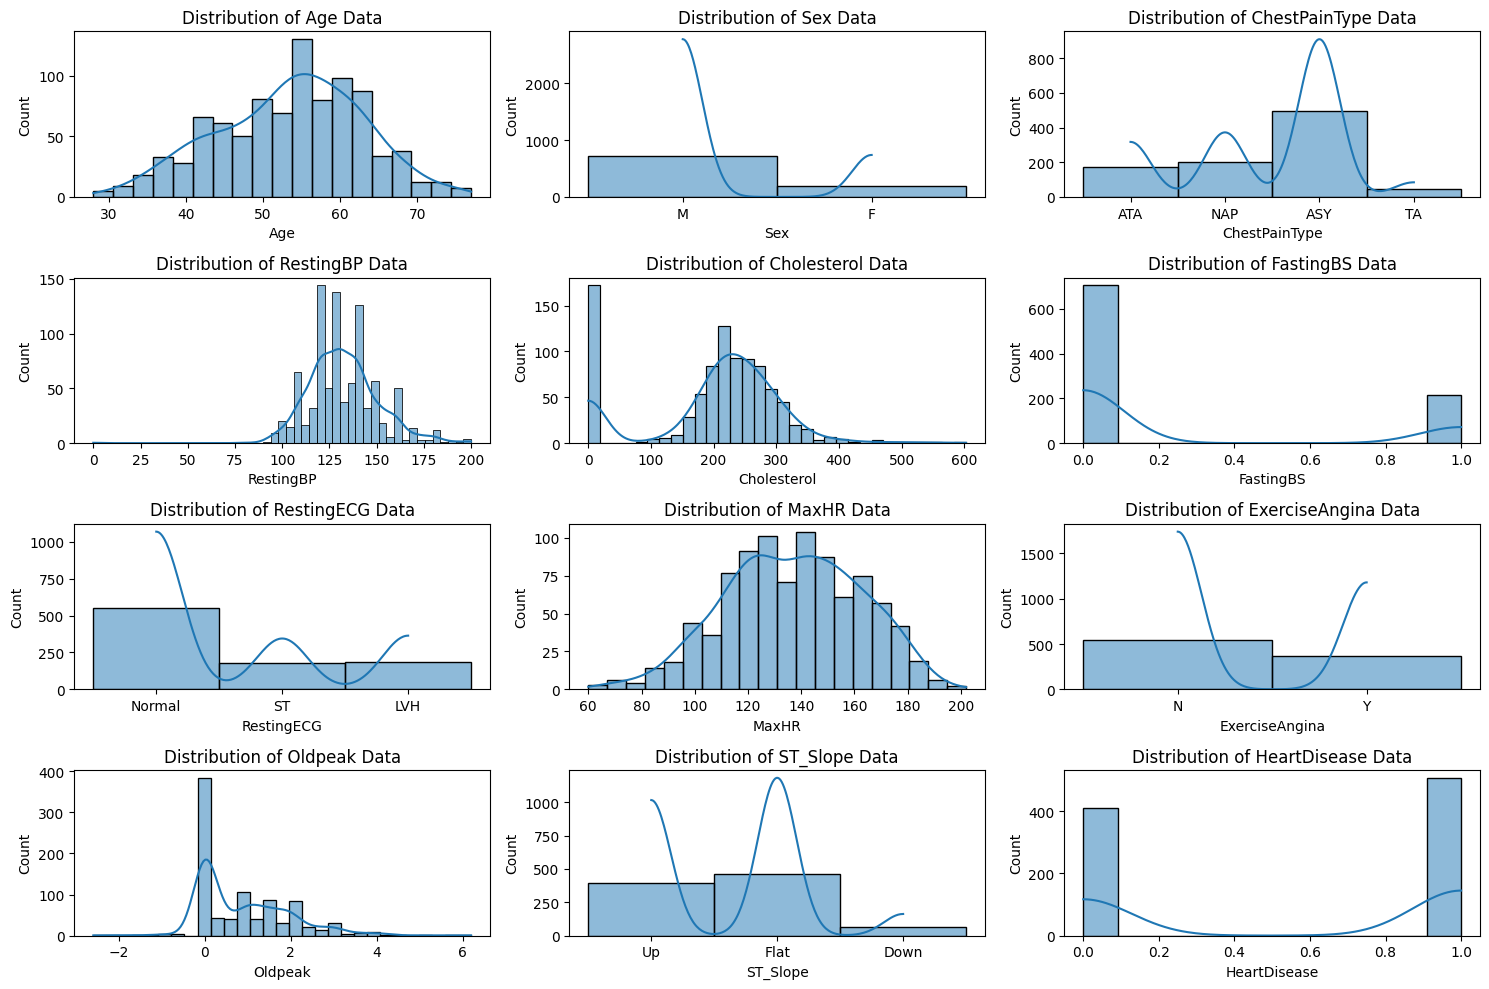

In [26]:
plt.figure(figsize=(15,10))
for i,col in enumerate(df.columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col],kde=True)
    plt.tight_layout()
    plt.plot()

Agora vamos checar os Outliers utilizando box plot

In [27]:
fig = px.box(df,y="Age",x="HeartDisease",title=f"Distribuição de Idade")
fig.show()

In [28]:
fig = px.box(df,y="RestingBP",x="HeartDisease",title=f"Distribuição do RestingBP",color="Sex")
fig.show()

In [29]:
df[df["RestingBP"]==0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


O paciente 449 tem dados inválidos

In [30]:
fig = px.box(df,y="Cholesterol",x="HeartDisease",title=f"Distribuição do Cholesterol")
fig.show()

In [31]:
df[df['Cholesterol'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


Tem 172 pacientes com dados faltantes para colesterol

In [32]:
df[df['Cholesterol'] >= 400]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
28,53,F,ATA,113,468,0,Normal,127,N,0.0,Up,0
30,53,M,NAP,145,518,0,Normal,130,N,0.0,Flat,1
69,44,M,ASY,150,412,0,Normal,170,N,0.0,Up,0
76,32,M,ASY,118,529,0,Normal,130,N,0.0,Flat,1
103,40,M,ASY,120,466,1,Normal,152,Y,1.0,Flat,1
149,54,M,ASY,130,603,1,Normal,125,Y,1.0,Flat,1
182,52,M,ASY,140,404,0,Normal,124,Y,2.0,Flat,1
250,44,M,ASY,135,491,0,Normal,135,N,0.0,Flat,1
496,58,M,ASY,132,458,1,Normal,69,N,1.0,Down,0
616,67,F,NAP,115,564,0,LVH,160,N,1.6,Flat,0


13 amostras com colesterol acima de 400. Apesar de ser muito alto tal métrica ainda é possível, embora seja extremamente alto e geralmente indique um problema sério de saúde. Isso pode ocorrer devido a condições genéticas, como a hipercolesterolemia familiar, ou devido a uma combinação de dieta inadequada, sedentarismo e outras doenças, como diabetes ou hipotireoidismo.

In [33]:
fig = px.box(df,y="Oldpeak",x="HeartDisease",title=f"Distribuição do Oldpeak")
fig.show()

In [34]:
fig = px.box(df,y="MaxHR",x="HeartDisease",title=f"Distribuição do MaxHR")
fig.show()

## Incio do pré-processamento dos dados

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    string 
 2   ChestPainType   918 non-null    string 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    string 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    string 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    string 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), string(5)
memory usage: 86.2 KB


In [36]:
#Checando se existe valores dados faltnates
df.isnull().sum()

,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


In [37]:
df.duplicated().sum()

0

In [38]:
df[df['Cholesterol'] == 237]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
187,41,M,ASY,120,237,1,Normal,138,Y,1.0,Flat,1
215,30,F,TA,170,237,0,ST,170,N,0.0,Up,0
246,54,M,NAP,120,237,0,Normal,150,Y,1.5,Flat,1
589,74,M,NAP,140,237,1,Normal,94,N,0.0,Flat,1
716,67,M,ASY,120,237,0,Normal,71,N,1.0,Flat,1


Retirando um dado inválido:

In [39]:
df2 = df[df['RestingBP'] != 0]
df2

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


Reiniciando o index após retirar o dado:

In [40]:
df2.reset_index(drop=True, inplace=True)
df2

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
912,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
913,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
914,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
915,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [41]:
# Calcular a mediana da coluna (ignorando os valores zerados)
mediana_colesterol = df2[df2['Cholesterol'] > 0]['Cholesterol'].median()
mediana_colesterol

237.0

In [42]:
# Substituir os valores zero pela mediana
df2['Cholesterol'] = df2['Cholesterol'].replace(0, mediana_colesterol)

In [43]:
df2[df2['Cholesterol'] == 237]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
187,41,M,ASY,120,237,1,Normal,138,Y,1.0,Flat,1
215,30,F,TA,170,237,0,ST,170,N,0.0,Up,0
246,54,M,NAP,120,237,0,Normal,150,Y,1.5,Flat,1
293,65,M,ASY,115,237,0,Normal,93,Y,0.0,Flat,1
...,...,...,...,...,...,...,...,...,...,...,...,...
517,48,M,NAP,102,237,1,ST,110,Y,1.0,Down,1
534,56,M,ASY,130,237,0,LVH,122,Y,1.0,Flat,1
535,62,M,NAP,133,237,1,ST,119,Y,1.2,Flat,1
588,74,M,NAP,140,237,1,Normal,94,N,0.0,Flat,1


In [44]:
df3 = pd.get_dummies(df2, drop_first=True)

In [45]:
df3

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,45,110,264,0,132,1.2,1,True,False,False,True,True,False,False,True,False
913,68,144,193,1,141,3.4,1,True,False,False,False,True,False,False,True,False
914,57,130,131,0,115,1.2,1,True,False,False,False,True,False,True,True,False
915,57,130,236,0,174,0.0,1,False,True,False,False,False,False,False,True,False


In [46]:
X = df3.drop(["HeartDisease"], axis=1)
y = df3["HeartDisease"]

In [47]:
X

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,True,False,True,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,45,110,264,0,132,1.2,True,False,False,True,True,False,False,True,False
913,68,144,193,1,141,3.4,True,False,False,False,True,False,False,True,False
914,57,130,131,0,115,1.2,True,False,False,False,True,False,True,True,False
915,57,130,236,0,174,0.0,False,True,False,False,False,False,False,True,False


In [48]:
y

,HeartDisease
0,0
1,1
2,0
3,1
4,0
...,...
912,1
913,1
914,1
915,1


## Treinamento do Modelo

In [49]:
# K-Fold Cross Validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [50]:
# Definir os parâmetros para cada algoritmo
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21, 25],
    'metric': ['cityblock', 'euclidean', 'l1', 'l2', 'manhattan', 'cosine', 'nan_euclidean']
}

param_grid_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10, 15]
}

param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01, 0.1]
}

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear', 'saga']
}


In [51]:
#Inicializar dicionário de resultados
results = {
    'KNN': {'accuracy': [], 'precision': [], 'recall': [], 'f1': []},
    'RF': {'accuracy': [], 'precision': [], 'recall': [], 'f1': []},
    'MLP': {'accuracy': [], 'precision': [], 'recall': [], 'f1': []},
    'LR': {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
}

In [52]:
# Serve para "trazer uma visão computacional" para que o modelo possa trabalhar nos dados
X_array = X.values
y_array = y.values


Resultados com MinMaxScaler:

Fold 1/10


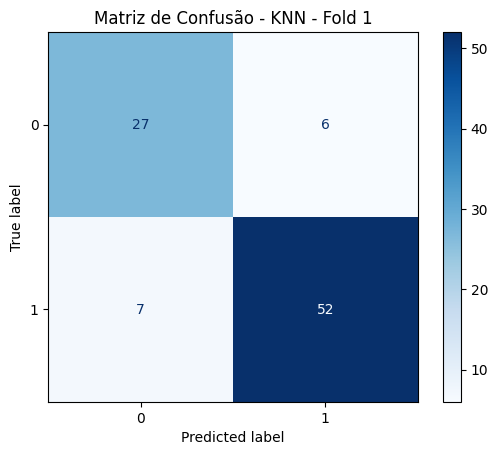


-----------------------------------------------------------------------------------



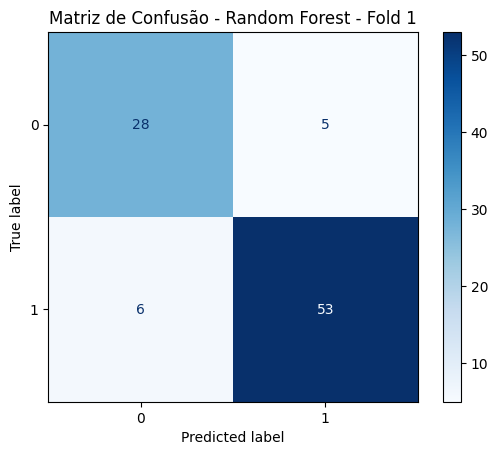


-----------------------------------------------------------------------------------



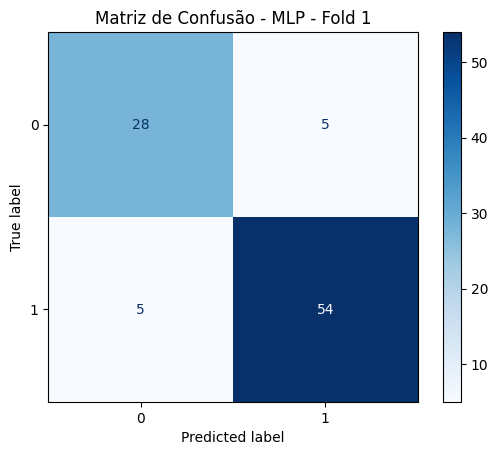


-----------------------------------------------------------------------------------



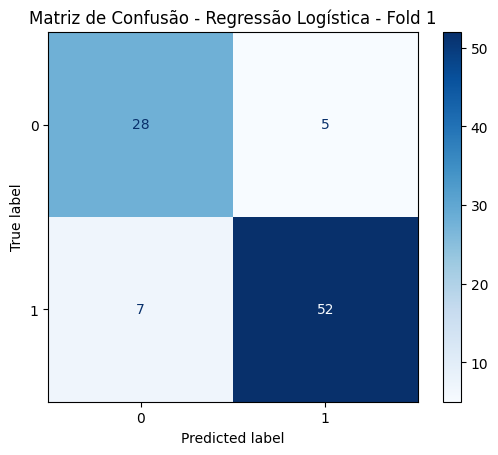


--------------------------------- RESULTADOS ---------------------------------

Fold 1/10:
KNN - Accuracy: 0.8587
RF - Accuracy: 0.8804
MLP - Accuracy: 0.8913
LR - Accuracy: 0.8696

Fold 2/10


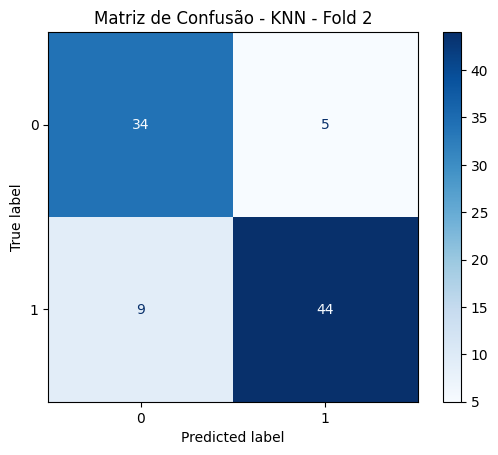


-----------------------------------------------------------------------------------



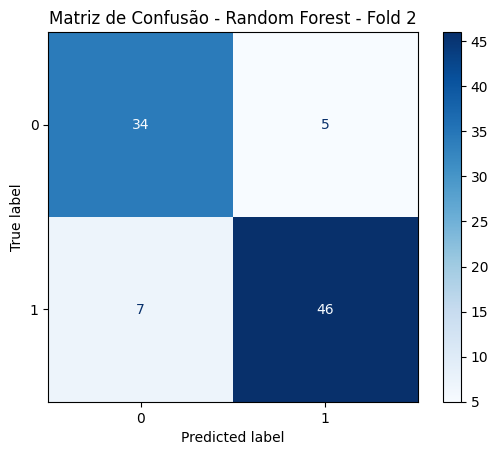


-----------------------------------------------------------------------------------



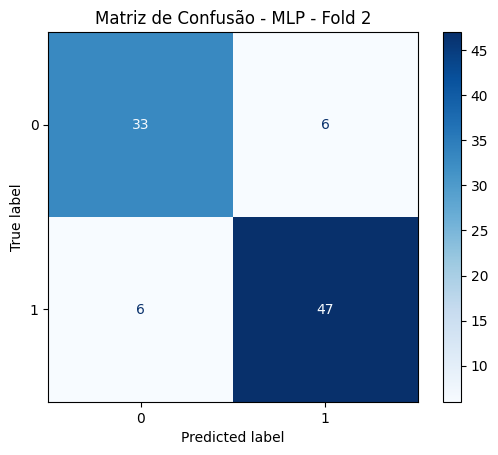


-----------------------------------------------------------------------------------



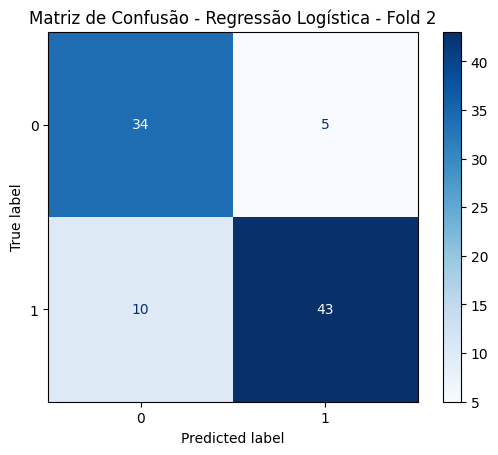


--------------------------------- RESULTADOS ---------------------------------

Fold 2/10:
KNN - Accuracy: 0.8478
RF - Accuracy: 0.8696
MLP - Accuracy: 0.8696
LR - Accuracy: 0.8370

Fold 3/10


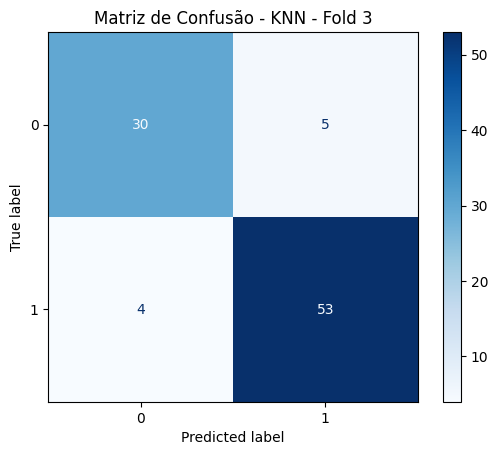


-----------------------------------------------------------------------------------



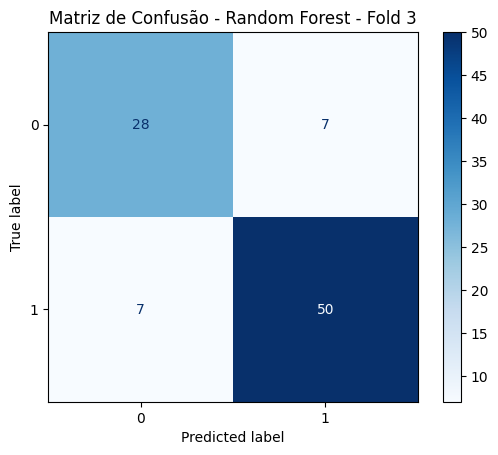


-----------------------------------------------------------------------------------



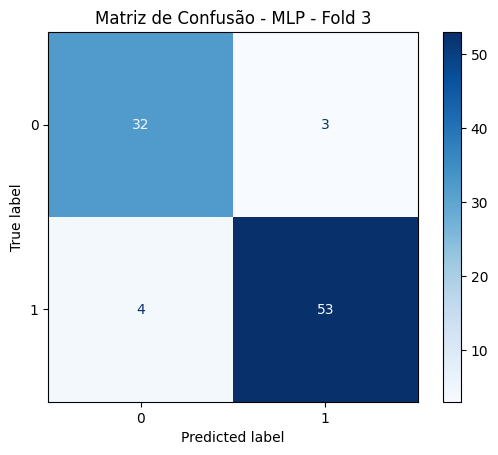


-----------------------------------------------------------------------------------



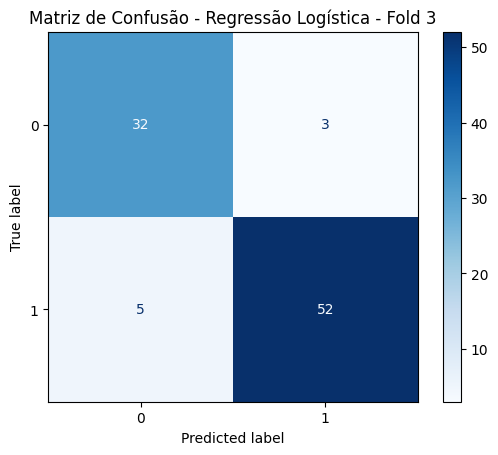


--------------------------------- RESULTADOS ---------------------------------

Fold 3/10:
KNN - Accuracy: 0.9022
RF - Accuracy: 0.8478
MLP - Accuracy: 0.9239
LR - Accuracy: 0.9130

Fold 4/10


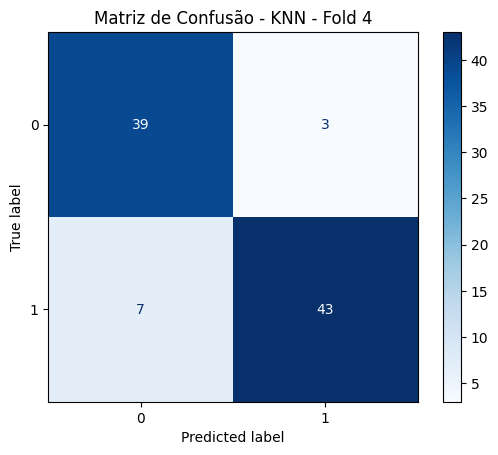


-----------------------------------------------------------------------------------



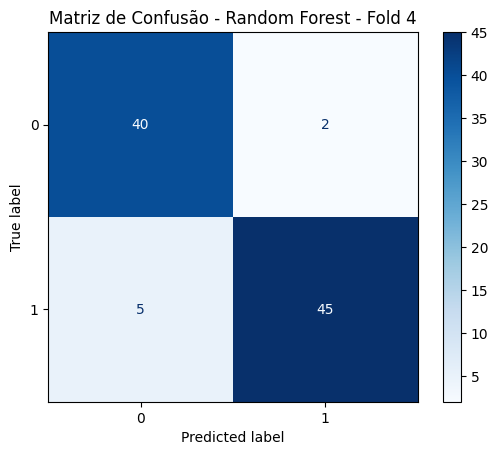


-----------------------------------------------------------------------------------



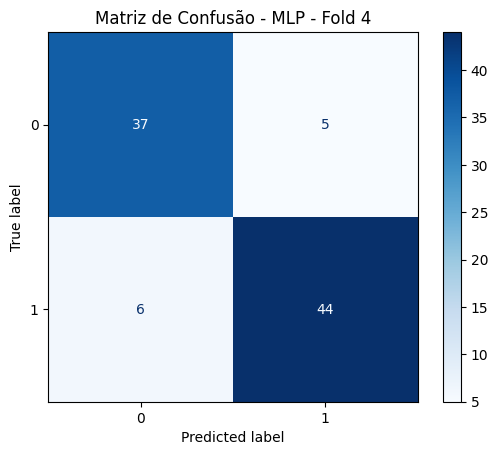


-----------------------------------------------------------------------------------



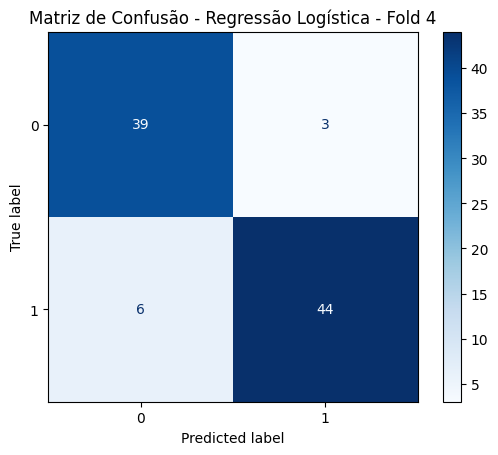


--------------------------------- RESULTADOS ---------------------------------

Fold 4/10:
KNN - Accuracy: 0.8913
RF - Accuracy: 0.9239
MLP - Accuracy: 0.8804
LR - Accuracy: 0.9022

Fold 5/10


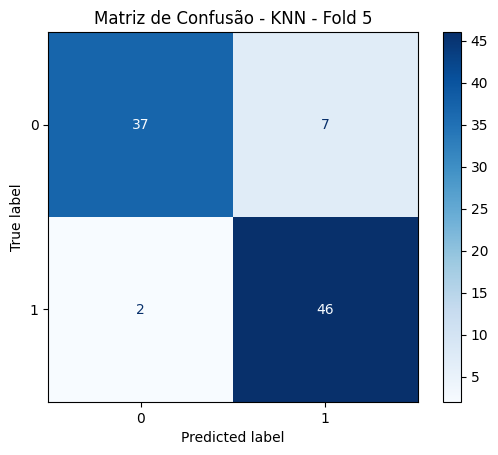


-----------------------------------------------------------------------------------



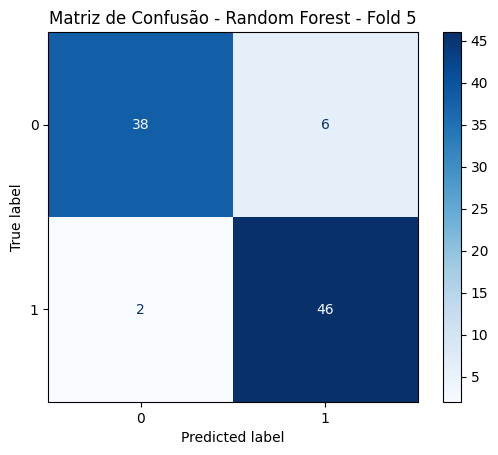


-----------------------------------------------------------------------------------



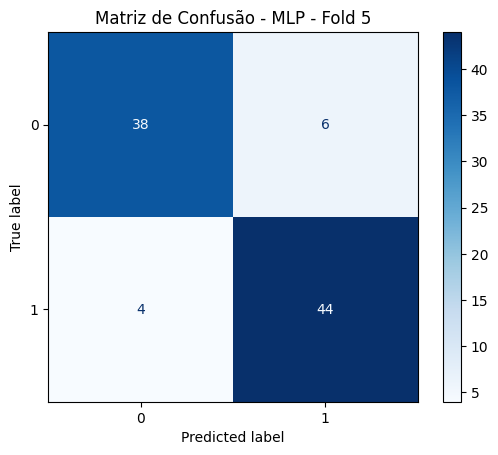


-----------------------------------------------------------------------------------



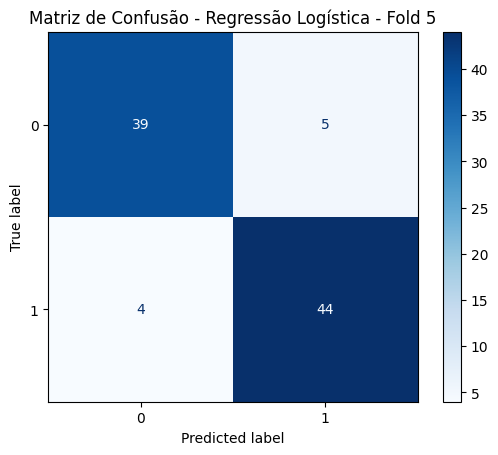


--------------------------------- RESULTADOS ---------------------------------

Fold 5/10:
KNN - Accuracy: 0.9022
RF - Accuracy: 0.9130
MLP - Accuracy: 0.8913
LR - Accuracy: 0.9022

Fold 6/10


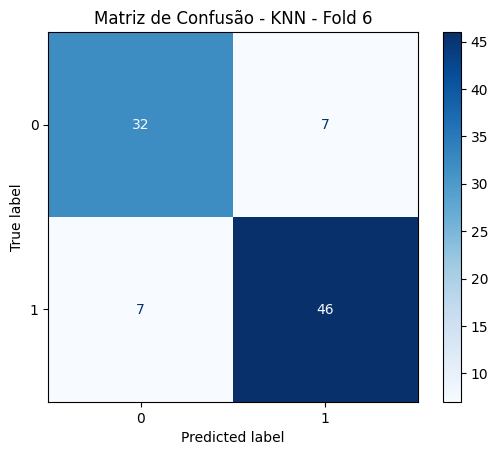


-----------------------------------------------------------------------------------



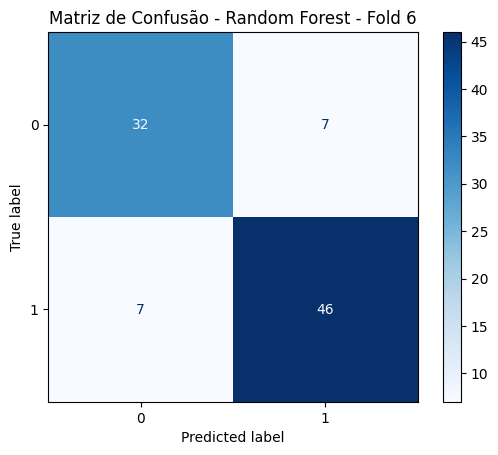


-----------------------------------------------------------------------------------



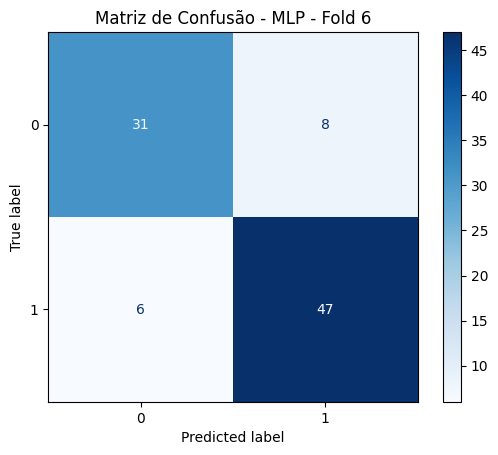


-----------------------------------------------------------------------------------



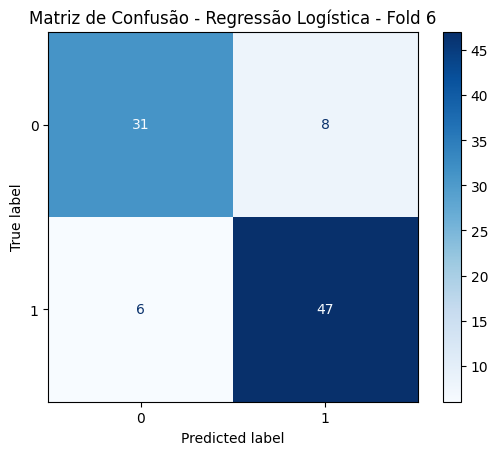


--------------------------------- RESULTADOS ---------------------------------

Fold 6/10:
KNN - Accuracy: 0.8478
RF - Accuracy: 0.8478
MLP - Accuracy: 0.8478
LR - Accuracy: 0.8478

Fold 7/10


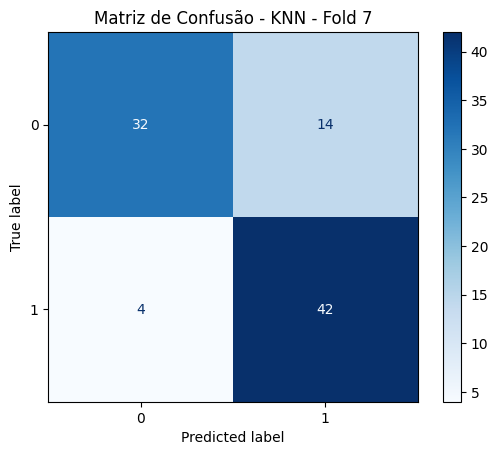


-----------------------------------------------------------------------------------



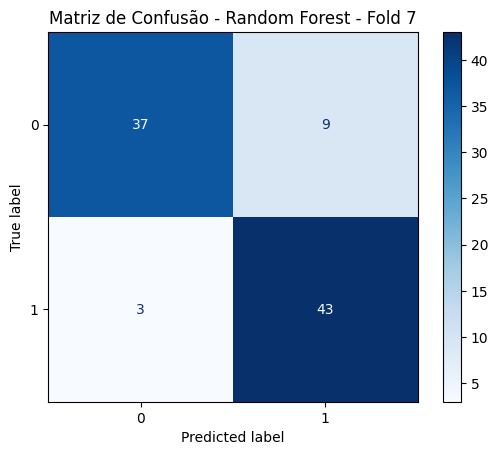


-----------------------------------------------------------------------------------



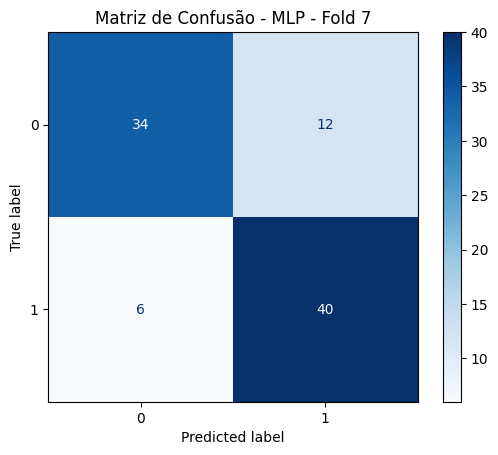


-----------------------------------------------------------------------------------



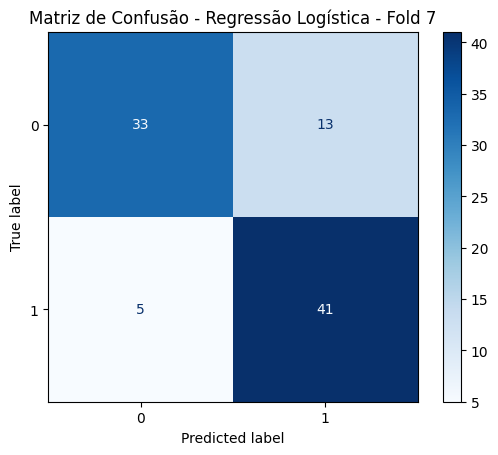


--------------------------------- RESULTADOS ---------------------------------

Fold 7/10:
KNN - Accuracy: 0.8043
RF - Accuracy: 0.8696
MLP - Accuracy: 0.8043
LR - Accuracy: 0.8043

Fold 8/10


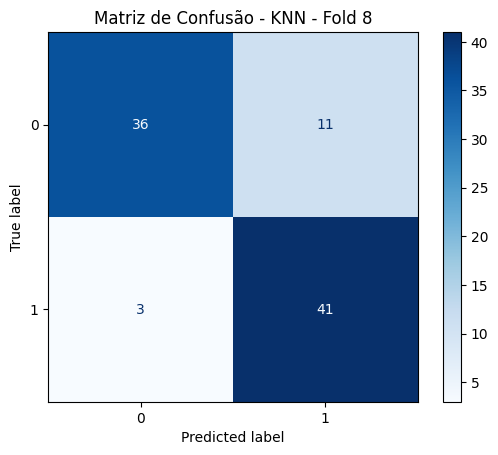


-----------------------------------------------------------------------------------



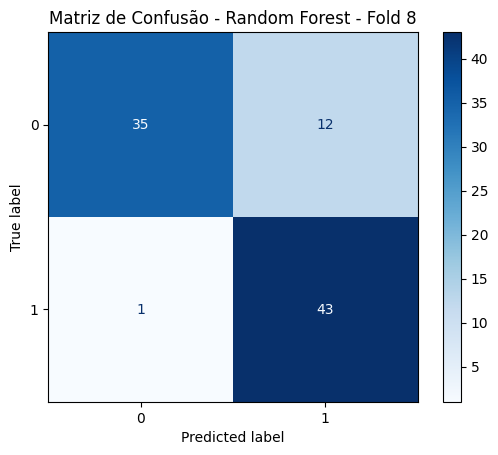


-----------------------------------------------------------------------------------



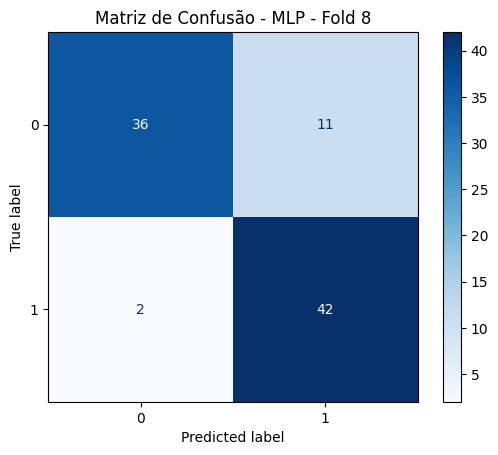


-----------------------------------------------------------------------------------



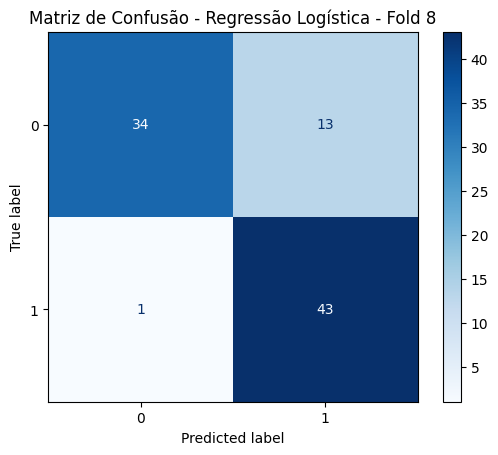


--------------------------------- RESULTADOS ---------------------------------

Fold 8/10:
KNN - Accuracy: 0.8462
RF - Accuracy: 0.8571
MLP - Accuracy: 0.8571
LR - Accuracy: 0.8462

Fold 9/10


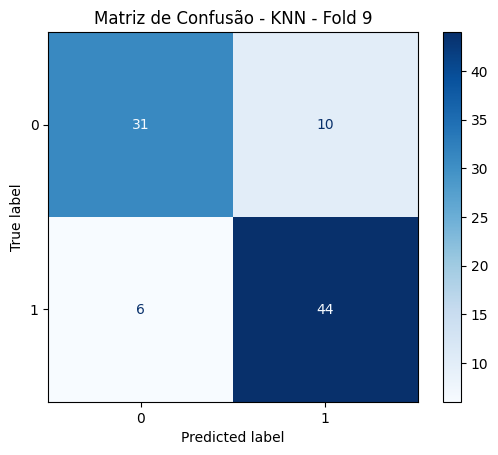


-----------------------------------------------------------------------------------



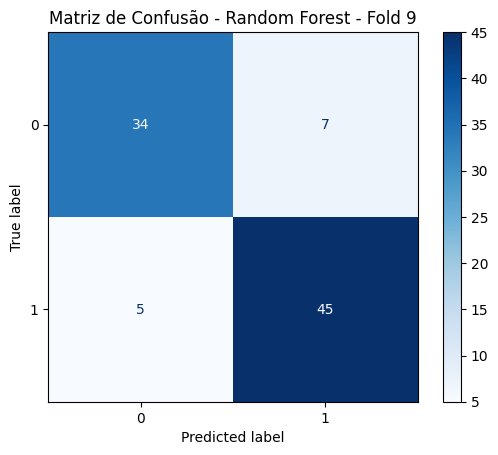


-----------------------------------------------------------------------------------



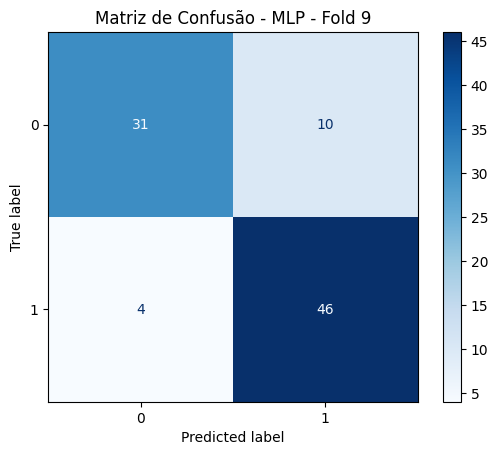


-----------------------------------------------------------------------------------



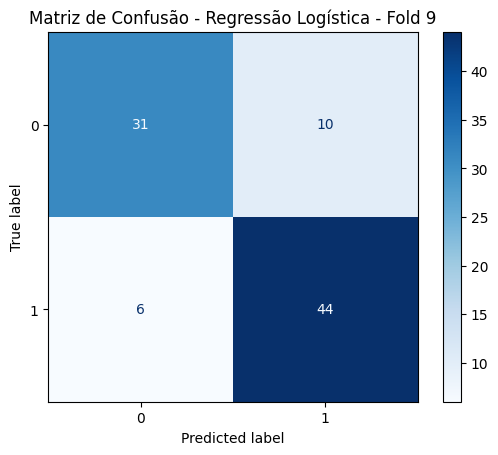


--------------------------------- RESULTADOS ---------------------------------

Fold 9/10:
KNN - Accuracy: 0.8242
RF - Accuracy: 0.8681
MLP - Accuracy: 0.8462
LR - Accuracy: 0.8242

Fold 10/10


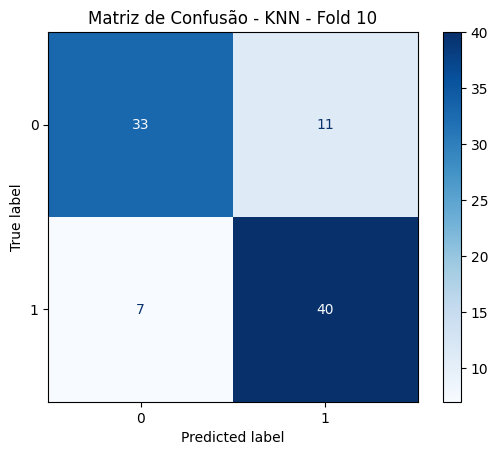


-----------------------------------------------------------------------------------



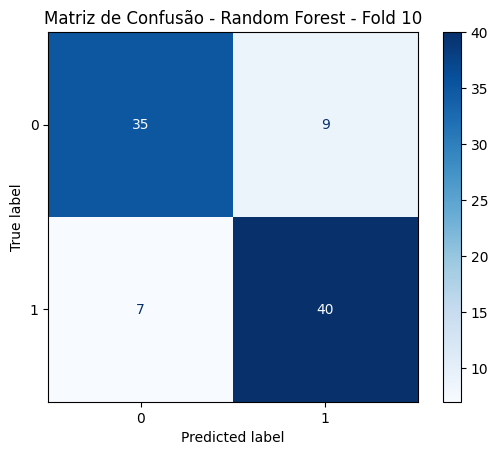


-----------------------------------------------------------------------------------



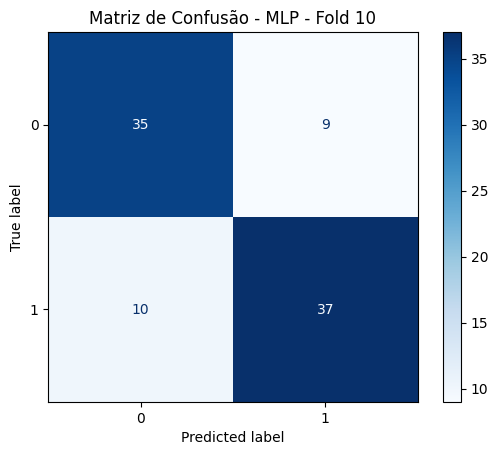


-----------------------------------------------------------------------------------



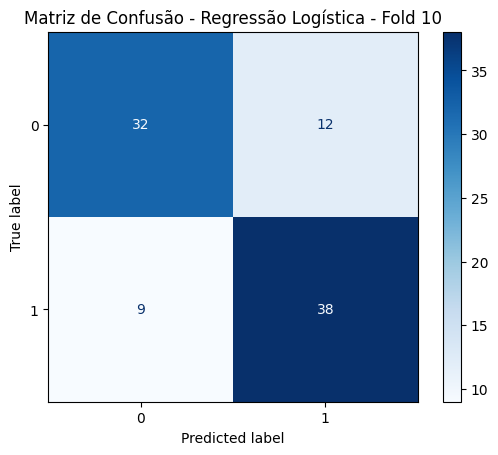


--------------------------------- RESULTADOS ---------------------------------

Fold 10/10:
KNN - Accuracy: 0.8022
RF - Accuracy: 0.8242
MLP - Accuracy: 0.7912
LR - Accuracy: 0.7692


In [54]:
# Normalização
scaler = MinMaxScaler()
scaler_name = type(scaler).__name__
print(f"\nResultados com {scaler_name}:")

# Loop para cada fold
for fold_idx, (train_index, test_index) in enumerate(kfold.split(X_array)):
    print(f"\nFold {fold_idx + 1}/10")

    # Separar dados
    X_train, X_test = X_array[train_index], X_array[test_index]
    y_train, y_test = y_array[train_index], y_array[test_index]

    # Separar conjunto de validação
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    # Normalizar dados
    X_train_split_s = scaler.fit_transform(X_train_split)
    X_val_s = scaler.transform(X_val)

    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    # KNN
    best_score_knn = 0
    best_params_knn = None
    for params in ParameterGrid(param_grid_knn):
        knn = KNeighborsClassifier(**params)
        knn.fit(X_train_split_s, y_train_split)
        y_pred = knn.predict(X_val_s)
        score = accuracy_score(y_val, y_pred)
        if score > best_score_knn:
            best_score_knn = score
            best_params_knn = params

    knn_final = KNeighborsClassifier(**best_params_knn)
    knn_final.fit(X_train_s, y_train)
    y_pred_knn = knn_final.predict(X_test_s)

    results['KNN']['accuracy'].append(accuracy_score(y_test, y_pred_knn))
    results['KNN']['precision'].append(precision_score(y_test, y_pred_knn, average='weighted'))
    results['KNN']['recall'].append(recall_score(y_test, y_pred_knn, average='weighted'))
    results['KNN']['f1'].append(f1_score(y_test, y_pred_knn, average='weighted'))

    cm = confusion_matrix(y_test, y_pred_knn)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Matriz de Confusão - KNN - Fold {fold_idx + 1}')
    plt.show()
    print("\n-----------------------------------------------------------------------------------\n")

    # Random Forest
    best_score_rf = 0
    best_params_rf = None
    for params in ParameterGrid(param_grid_rf):
        rf = RandomForestClassifier(**params)
        rf.fit(X_train_split_s, y_train_split)
        y_pred = rf.predict(X_val_s)
        score = accuracy_score(y_val, y_pred)
        if score > best_score_rf:
            best_score_rf = score
            best_params_rf = params

    rf_final = RandomForestClassifier(**best_params_rf)
    rf_final.fit(X_train_s, y_train)
    y_pred_rf = rf_final.predict(X_test_s)

    results['RF']['accuracy'].append(accuracy_score(y_test, y_pred_rf))
    results['RF']['precision'].append(precision_score(y_test, y_pred_rf, average='weighted'))
    results['RF']['recall'].append(recall_score(y_test, y_pred_rf, average='weighted'))
    results['RF']['f1'].append(f1_score(y_test, y_pred_rf, average='weighted'))

    cm = confusion_matrix(y_test, y_pred_rf)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Matriz de Confusão - Random Forest - Fold {fold_idx + 1}')
    plt.show()
    print("\n-----------------------------------------------------------------------------------\n")

    # MLP
    best_score_mlp = 0
    best_params_mlp = None
    for params in ParameterGrid(param_grid_mlp):
        mlp = MLPClassifier(max_iter=1000, **params)
        mlp.fit(X_train_split_s, y_train_split)
        y_pred = mlp.predict(X_val_s)
        score = accuracy_score(y_val, y_pred)
        if score > best_score_mlp:
            best_score_mlp = score
            best_params_mlp = params

    mlp_final = MLPClassifier(max_iter=1000, **best_params_mlp)
    mlp_final.fit(X_train_s, y_train)
    y_pred_mlp = mlp_final.predict(X_test_s)

    results['MLP']['accuracy'].append(accuracy_score(y_test, y_pred_mlp))
    results['MLP']['precision'].append(precision_score(y_test, y_pred_mlp, average='weighted'))
    results['MLP']['recall'].append(recall_score(y_test, y_pred_mlp, average='weighted'))
    results['MLP']['f1'].append(f1_score(y_test, y_pred_mlp, average='weighted'))

    cm = confusion_matrix(y_test, y_pred_mlp)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Matriz de Confusão - MLP - Fold {fold_idx + 1}')
    plt.show()
    print("\n-----------------------------------------------------------------------------------\n")

    # Regressão Logística
    best_score_lr = 0
    best_params_lr = None
    for params in ParameterGrid(param_grid_lr):
        lr = LogisticRegression(**params, max_iter=500)
        lr.fit(X_train_split_s, y_train_split)
        y_pred = lr.predict(X_val_s)
        score = accuracy_score(y_val, y_pred)
        if score > best_score_lr:
            best_score_lr = score
            best_params_lr = params

    # Treinar modelo final com os melhores parâmetros
    lr_final = LogisticRegression(**best_params_lr, max_iter=500)
    lr_final.fit(X_train_s, y_train)
    y_pred_lr = lr_final.predict(X_test_s)

    # Calcular métricas
    results['LR']['accuracy'].append(accuracy_score(y_test, y_pred_lr))
    results['LR']['precision'].append(precision_score(y_test, y_pred_lr))
    results['LR']['recall'].append(recall_score(y_test, y_pred_lr))
    results['LR']['f1'].append(f1_score(y_test, y_pred_lr))

    cm = confusion_matrix(y_test, y_pred_lr)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Matriz de Confusão - Regressão Logística - Fold {fold_idx + 1}')
    plt.show()

    print("\n--------------------------------- RESULTADOS ---------------------------------\n")
    print(f"Fold {fold_idx + 1}/10:")
    print(f"KNN - Accuracy: {results['KNN']['accuracy'][-1]:.4f}")
    print(f"RF - Accuracy: {results['RF']['accuracy'][-1]:.4f}")
    print(f"MLP - Accuracy: {results['MLP']['accuracy'][-1]:.4f}")
    print(f"LR - Accuracy: {results['LR']['accuracy'][-1]:.4f}")


## Resultados e Métricas

In [55]:
# Imprimir resultados finais
print("\nResultados Finais:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric_name, values in metrics.items():
        print(f"{metric_name}: {np.mean(values):.4f} (±{np.std(values):.4f})")



Resultados Finais:

KNN:
accuracy: 0.8552 (±0.0355)
precision: 0.8593 (±0.0341)
recall: 0.8552 (±0.0355)
f1: 0.8548 (±0.0359)

RF:
accuracy: 0.8705 (±0.0266)
precision: 0.8744 (±0.0276)
recall: 0.8705 (±0.0266)
f1: 0.8703 (±0.0267)

MLP:
accuracy: 0.8531 (±0.0379)
precision: 0.8569 (±0.0367)
recall: 0.8531 (±0.0379)
f1: 0.8527 (±0.0382)

LR:
accuracy: 0.8545 (±0.0406)
precision: 0.8567 (±0.0669)
recall: 0.8870 (±0.0420)
f1: 0.8697 (±0.0395)


In [58]:
import numpy as np
from scipy.stats import wilcoxon

models = list(results.keys())
alpha = 0.05  # Nível de significância
metrics = ['accuracy', 'precision', 'recall', 'f1']

for metric in metrics:
    print(f"\nTeste de Wilcoxon (p-values para {metric}):")
    for i in range(len(models)):
        for j in range(i + 1, len(models)):
            # Obtém os arrays para a métrica atual para os dois modelos
            m1 = np.array(results[models[i]][metric])
            m2 = np.array(results[models[j]][metric])

            if len(m1) != len(m2):
                min_len = min(len(m1), len(m2))
                m1 = m1[:min_len]
                m2 = m2[:min_len]

            if np.all(m1 == m2):
                continue

            stat, p_value = wilcoxon(m1, m2)
            print(f"{models[i]} vs {models[j]}: {p_value:.4f}", end=" ")

            if p_value < alpha:
                print("(Diferença significativa)")
            else:
                print("(Diferença **não** significativa)")



Teste de Wilcoxon (p-values para accuracy):
KNN vs RF: 0.0100 (Diferença significativa)
KNN vs MLP: 0.8707 (Diferença **não** significativa)
KNN vs LR: 0.4984 (Diferença **não** significativa)
RF vs MLP: 0.0032 (Diferença significativa)
RF vs LR: 0.0103 (Diferença significativa)
MLP vs LR: 0.8974 (Diferença **não** significativa)

Teste de Wilcoxon (p-values para precision):
KNN vs RF: 0.0115 (Diferença significativa)
KNN vs MLP: 0.9741 (Diferença **não** significativa)
KNN vs LR: 0.8553 (Diferença **não** significativa)
RF vs MLP: 0.0020 (Diferença significativa)
RF vs LR: 0.2286 (Diferença **não** significativa)
MLP vs LR: 0.7303 (Diferença **não** significativa)

Teste de Wilcoxon (p-values para recall):
KNN vs RF: 0.0100 (Diferença significativa)
KNN vs MLP: 0.8707 (Diferença **não** significativa)
KNN vs LR: 0.0004 (Diferença significativa)
RF vs MLP: 0.0032 (Diferença significativa)
RF vs LR: 0.0732 (Diferença **não** significativa)
MLP vs LR: 0.0003 (Diferença significativa)

T